



# **Lab 6: Fully Connected Network (2)**

<p align="justify"> In this Lab we are going to enhance our previous fully connected model on MNIST dataset.


<a name="1"></a>
## 	 Importing necessary libraries and dataset






In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import random
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_dataset = train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transform,
                                          download=False)

In [ ]:
#setting all seeds to the same number for reproducability
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

## **Hyperparameter tuning:**
**Fixed** hyperparamters are the ones that we can not change during our experiments. Input size (which is calculated based on the dimentions of our input images), number of classes present in the dataset and the size of the validation set are our fixed hyperparamters.



In [ ]:
#fixed hyperparamters
input_size = 784
num_classes = 10
validation_size = 0.2

In [ ]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=validation_size, random_state=42)

**Tunable** hyperparameters are hyperparameters that can be adjusted during the training process to improve the performance of the model. The optimal values for these hyperparameters are typically found through experimentation and validation.



In [ ]:
#tunable hyperparameter
batch_size = 100

In [ ]:
# Data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# The test_loader remains unchanged for the test set
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


### Hidden layers
<p align="justify"> In our last lab, we implemented a simple fully connected model with just an input layer and an output layer. In this session, we will take it a step further by adding multiple hidden layers to the model.


<p align="justify"> The main function of hidden layers is to transform the input data into a form that the output layer can use to make predictions. They do this by applying weights to the input data, adding a bias term, and passing the result through an activation function. This process allows the model to learn more complex, non-linear relationships between the inputs and outputs.

**How Hidden Layers Work**

<p align="justify"> In each hidden layer every neuron receives inputs from all neurons in the previous layer. Each input is multiplied by a specific weight, and a bias is added.
This weighted sum is then passed through an activation function, which introduces non-linearity to the model.
The output of each neuron becomes the input for the next layer, allowing the network to learn deeper patterns and make more accurate predictions as it progresses through the layers.

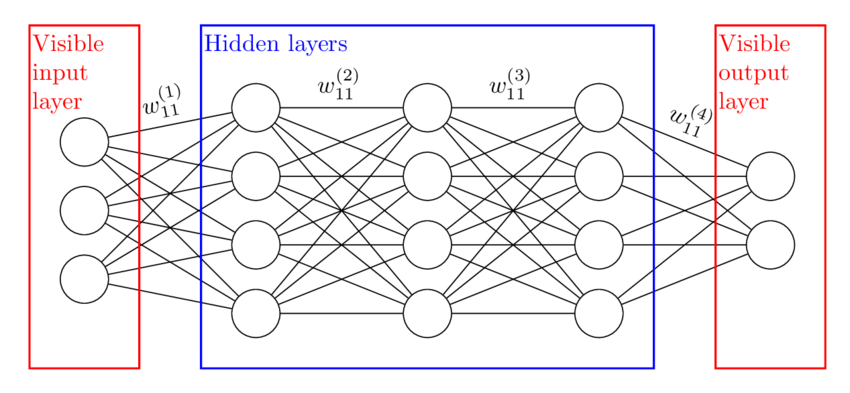

Image source: https://deepai.org/

We want to add 2 hidden layers to our model. So we define a list of hidden sizes:

In [ ]:
#tunable hyperparameters
hidden_sizes = [512, 256, 128]

### Dropouts
<p align="justify"> Large neural networks trained on small or simple data have high chance of overfitting, where the model captures noise in the training data, leading to higher generalization error (loss).

<p align="justify"> Dropout is a technique used to prevent overfitting. It works by randomly "dropping out" some of the neurons in the network during training. This means that those neurons don't contribute to the forward pass or the backward pass during that training iteration.

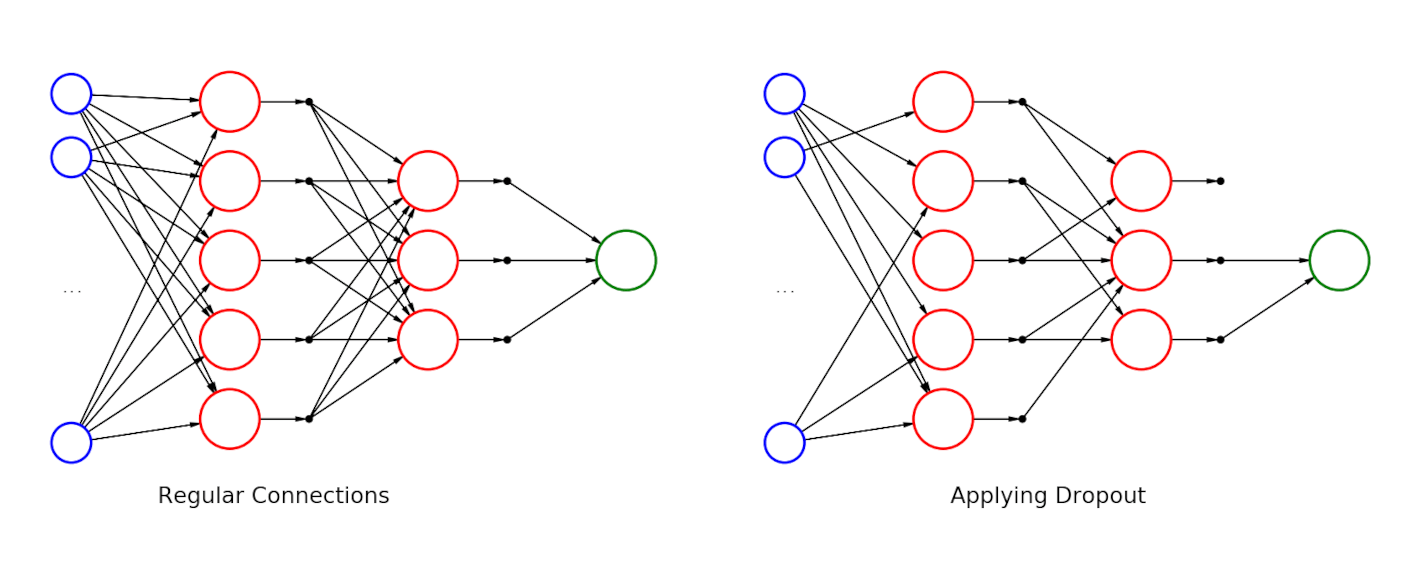


Dropout may be implemented on any or all hidden layers in the network as well as the input layer. However, it is not used on the output layer. The dropout rate specifies the probability at which outputs of the layer are dropped out.

You can define different dropout rates for different layers but for this lab we will use the same rate for all layers:

In [ ]:
dropout_rate = 0.2

### Batch normalization

<p align="justify"> **Batch Normalization** is a technique used to enhance the training of deep neural networks by normalizing the inputs of each layer to have a mean of zero and a standard deviation of one. This helps address the issue of **internal covariate shift**—the change in the distribution of activations as weights are updated. As deeper layers depend on the outputs of earlier layers, even small changes in the initial layers can amplify and lead to significant shifts in the distribution of inputs to deeper layers. This can result in the need for lower learning rates and careful parameter initialization, making the training process slow and less efficient.

<p align="justify"> By stabilizing these activations, batch normalization allows for faster training, reduces the need for careful parameter initialization, and helps the network generalize better.

The batch normalization layers are implemented after every layer of the model except for the output layer.

<a name="1"></a>
## Build the mode
Now that we have defined the new hyperparameters, let's build our new model:
<p align="justify"></p>


In [ ]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0]) #batch normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 =nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 =nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 =  nn.BatchNorm1d(hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)


    def forward(self, x):

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        return out

model = FCNet(input_size, hidden_sizes, num_classes).to(device)


Let's look at our model:

In [ ]:
print(model)

FCNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


<a name="1"></a>
##  Optimizer and Loss function
For this lab we will use Adam optimizer instead of SGD with Cross entropy loss function. Addtionally we will lower the learninig rate to 0.0001:


In [ ]:
#tunable hyperparameter
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<a name="1"></a>
## Train and validation functions






In [ ]:
#train function

def Train(model,train_loader,optimizer):
    model.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy


In [ ]:
#validation function

def Validate(model,val_loader):
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in val_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (100 * correct / total)
  return loss.item(),accuracy

### Epochs
The number of epochs affects model performance by influencing its ability to learn patterns. With too few epochs, the model may underfit, meaning it has not learned enough and performs poorly on both training and validation data. With too many epochs, the model may overfit, capturing noise and details specific to the training data, which reduces its ability to generalize to new data.

Ideally, the right number of epochs allows the model to reach high accuracy on both training and validation sets without overfitting. Using techniques like early stopping and monitoring train and validation metrics helps determine the right number of epochs for the best model performance.

We choose 20 epochs fo our training:

In [ ]:
#tunable hyperparameter
num_epochs = 20

<a name="1"></a>
## Run


In [ ]:
T_loss= []
v_loss =[]
T_acc = []
v_acc = []
# run
for epoch in range(num_epochs):
  train_loss, train_acc = Train(model, train_loader, optimizer)
  val_loss, val_acc = Validate(model, val_loader)

  print ('Epoch [{}/{}], train Loss: {:.4f}, train acc: {:.4f}, val Loss: {:.4f} , val acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss,train_acc, val_loss,val_acc))
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)


Epoch [1/20], train Loss: 0.4194, train acc: 83.9354, val Loss: 0.2013 , val acc: 93.9917
Epoch [2/20], train Loss: 0.2470, train acc: 93.7625, val Loss: 0.1129 , val acc: 96.0333
Epoch [3/20], train Loss: 0.1782, train acc: 95.4583, val Loss: 0.0861 , val acc: 96.9583
Epoch [4/20], train Loss: 0.1723, train acc: 96.6021, val Loss: 0.0707 , val acc: 97.2583
Epoch [5/20], train Loss: 0.0566, train acc: 97.1417, val Loss: 0.0576 , val acc: 97.4000
Epoch [6/20], train Loss: 0.1013, train acc: 97.5875, val Loss: 0.0631 , val acc: 97.6000
Epoch [7/20], train Loss: 0.0261, train acc: 97.8604, val Loss: 0.0543 , val acc: 97.8250
Epoch [8/20], train Loss: 0.0517, train acc: 98.1167, val Loss: 0.0509 , val acc: 97.9917
Epoch [9/20], train Loss: 0.0184, train acc: 98.3312, val Loss: 0.0493 , val acc: 98.0667
Epoch [10/20], train Loss: 0.0983, train acc: 98.3667, val Loss: 0.0527 , val acc: 97.9833
Epoch [11/20], train Loss: 0.0492, train acc: 98.6479, val Loss: 0.0540 , val acc: 97.9250
Epoch [1

<a name="8"></a>
## Analysing model performance



####  Plots


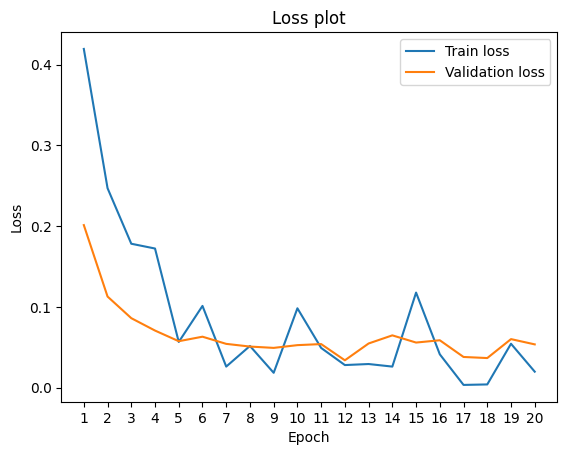

In [ ]:
epochs = [i for i in range (1,num_epochs+1)]
plt.plot(epochs, T_loss, label='Train loss')
plt.plot(epochs, v_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(epochs)
plt.legend()
plt.show()


**Questions:**
* Do you think 20 was a good number of epochs for this task?
* If you had limited resources and needed to use fewer epochs, what is the minimum number of epochs you would choose to optimize time while maximizing performance?


<font color='red'>Yes, from the results we can see an improvement in training and validation metrics over the epochs, reahcing a stabilized validation accuracy and loss at the end, so using 20 epochs seems to be a reasonable choice.

<font color='red'> At epoch 20, the model's results are val Loss: 0.0536, val acc: 98.3. By comparing the validation loss and accuracy over 20 epochs, we can see that the model reaches its lowest validation loss of 0.0339 at Epoch 12 with a validation accuracy of 98.18%. At this point, the model has already learned enough, and afterward, its performance fluctuates. If I had limited resources, I would stick with 12 epochs, as the model reaches the desired validation performance by that point.

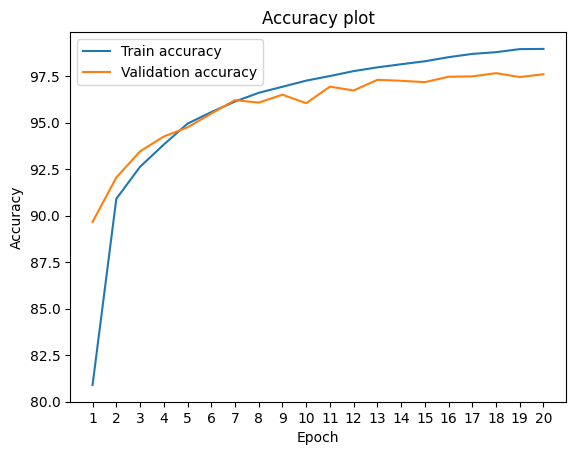

In [ ]:

plt.plot(epochs, T_acc, label='Train accuracy')
plt.plot(epochs, v_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.xticks(epochs)
plt.legend()
plt.show()


**Question:**
Based on the plots and the train metrics, how do you think this model is performing?

<font color='red'>Based on the plots and the train metrics, the model is performing well.  Both training and validation steadily increase, showing that the model is learning and can generalize. We also notice that the training and validation loss decrease over the epochs; however, after certain iterations, it fluctuates. This indicates that if we continue to iterate, it may lead to overfitting.

<a name="1"></a>
## Testing


In [ ]:
model.eval()
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict.extend(predicted.tolist())



    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print(len(predict))

Accuracy of the network on the 10000 test images: 97.55 %
10000


**Question:** Compare this model's performance with the previous model we built in lab 5

<font color='red'>This model has higher accuracy result , compared to the  86.82% accuracy result from Lab5. The model's performance got enhanced.  We can say that adding additional layers increased the capacity of the model to learn complex patterns from the data.

<a name="1"></a>
## Confusion matrix


Confusion matrix, without normalization


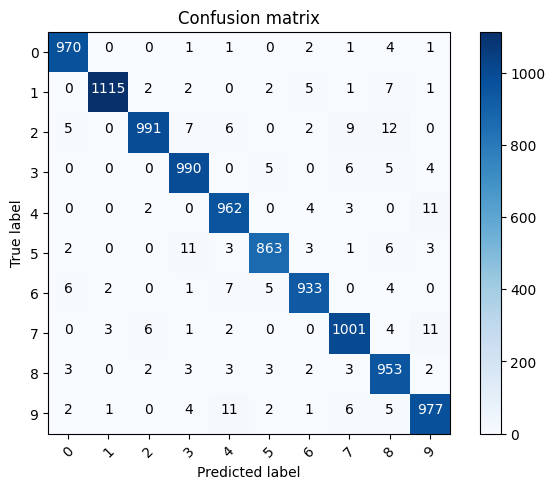

In [ ]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

x_test = []
y_test = []
for data, target in test_loader:
  x_test.extend(data)
  y_test.extend(target)

cm = confusion_matrix(y_test, predict)
plot_confusion_matrix(cm,list(range(10)))

**Question:** Which numbers does the model get confused with each other the most? why do you think this happens?

<font color='red'>The model gets confused the most with the pair of classes 4 and 9. When we check class 4's false negatives, the highest number is 11, which are predicted as 9. Similarly, for class 9's false negatives, the highest number is 11, predicted as 4.

<font color='red'>The potential reaons of  why the model gets confused between certain classes (like 4 and 9) can be visual similarities in their features or overlapping characteristics like having similar edge patterns. Also, insufficent hidden layers can also limit the model's capacity to capture distinct features. All of these factors can make it harder for the model to differentiate between them accurately.

<a name="1"></a>
##  Visualizing the hard samples

<p align="justify"> So far, we have seen how tuning hyperparameters can significantly improve the performance of our model, allowing us to achieve high accuracy and relatively low loss. By adjusting parameters we managed to optimize our model and push its accuracy closer to our goal. However, despite all these improvements, our model still does not achieve a perfect score of 100% accuracy.

<p align="justify"> This gap indicates that there may be some patterns in the data that our model has not fully captured or certain types of inputs where it struggles. To understand these limitations better, we can take a closer look at the incorrectly predicted samples. By visualizing these misclassified examples, we can gain insights into where and why the model is making mistakes.

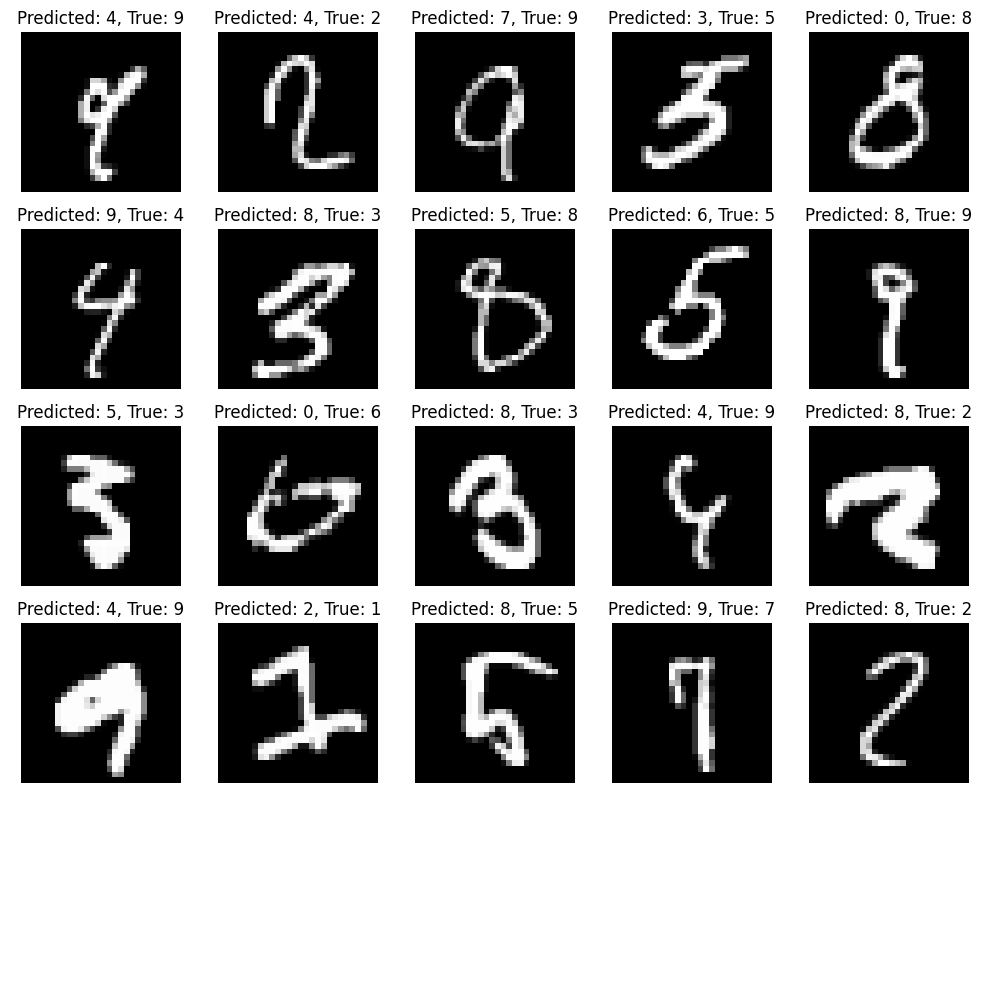

In [ ]:
def visualize_false_predictions(model, test_loader, num_samples, device):
    false_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    false_predictions.append((images[i].cpu().numpy(), predicted[i].item(), labels[i].item()))

    random.seed(41)
    false_predictions = random.sample(false_predictions, min(num_samples, len(false_predictions)))

    # Calculate the grid dimensions
    grid_size = int(num_samples**0.5)
    if grid_size * grid_size < num_samples:
        grid_size += 1

    # Create the figure and axes
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Display the false predictions in a grid
    for i, (image, predicted_label, true_label) in enumerate(false_predictions):
        ax = axes[i]
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.set_title(f"Predicted: {predicted_label}, True: {true_label}")
        ax.axis('off')  # Hide the axis

    # Hide any unused axes
    for i in range(len(false_predictions), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

#we take 20 samples to looks at:
visualize_false_predictions(model, test_loader,num_samples=20, device=device)

**Questions:**
* Why do you think these images were missclassified?


<font color='red'>I think these images were misclassified due to a combination of factors, including ambiguous written digits that resemble other numbers (8 looking like 3 or 0),  there are also similar features between certain digits (4 vs. 9 or 3 vs. 5), also potential limitations in the model's ability to generalize to diverse handwriting styles. Additionally, the model's insufficient training data for edge cases may also have contributed to the confusion.